<font size="+3"><strong>ARMA Models</strong></font>

In [1]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

In [3]:
pd.read_csv('Dar_es_Salaam.csv')

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,67;SDS011;42;-6.772;39.269;2019-04-01T00:02:19...
1,67;SDS011;42;-6.772;39.269;2019-04-01T00:02:19...
2,68;DHT22;42;-6.772;39.269;2019-04-01T00:02:20....
3,68;DHT22;42;-6.772;39.269;2019-04-01T00:02:20....
4,67;SDS011;42;-6.772;39.269;2019-04-01T00:04:50...
...,...
190023,63;DHT22;64;-6.778;39.252;2019-06-28T16:32:36....
190024,64;SDS011;64;-6.778;39.252;2019-06-28T16:35:05...
190025,64;SDS011;64;-6.778;39.252;2019-06-28T16:35:05...
190026,63;DHT22;64;-6.778;39.252;2019-06-28T16:35:06....


In [4]:
# Function to read and clean data
def wrangle_data(csv, resample_rule = "1H"):
    # Read data for data frame
    df = pd.read_csv(csv)

    df[['sensor_id','sensor_type', 'location', 'lat', 'lon', 'timestamp', 'value_type', 'value']] = (
        df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"]
        .str
        .split(";", expand = True)
    )
    df.drop(columns = "sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value", inplace = True)

    # Set timestamp as index
    df = df.set_index("timestamp")

    # Change to Datetime
    df.index = pd.to_datetime(df.index)

    #Localize Timezone
    city = csv.split(".")[0]
    df.index.tz_convert(f"Africa/{city}")

    df['value_type'] = df['value_type'].astype(str)
    df['value'] = df['value'].astype(float)

    # Since we are only focused on air quality, get only P2 readings
    mask = df['value_type'] == 'P2'
    filtered_data = df[mask]['value']

    # Create a new DataFrame from the filtered data
    df = pd.DataFrame({'P2': filtered_data})

    # Remove outliers
    df = df[df["P2"] < 400]

    # Resample and forward-fill
    y = df["P2"].resample(resample_rule).mean().fillna(method='ffill')

    return y

In [5]:
df_dar = wrangle_data('Dar_es_Salaam.csv')
print(df_dar.info())
df_dar.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2129 entries, 2019-04-01 00:00:00+00:00 to 2019-06-28 16:00:00+00:00
Freq: H
Series name: P2
Non-Null Count  Dtype  
--------------  -----  
2129 non-null   float64
dtypes: float64(1)
memory usage: 33.3 KB
None


timestamp
2019-04-01 00:00:00+00:00    11.613500
2019-04-01 01:00:00+00:00     9.219167
2019-04-01 02:00:00+00:00     9.232083
2019-04-01 03:00:00+00:00     9.374583
2019-04-01 04:00:00+00:00    13.673750
Freq: H, Name: P2, dtype: float64

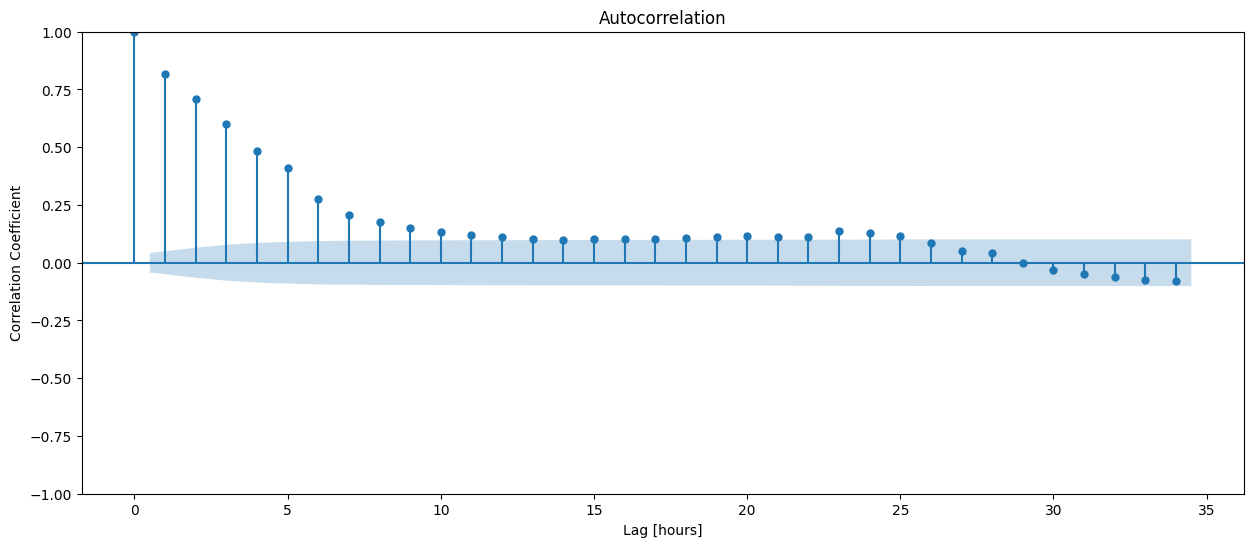

In [6]:
# Creating an ACF plot to display autocorrelation coefficients
fig, ax = plt.subplots(figsize = (15,6))
plot_acf(df_dar, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

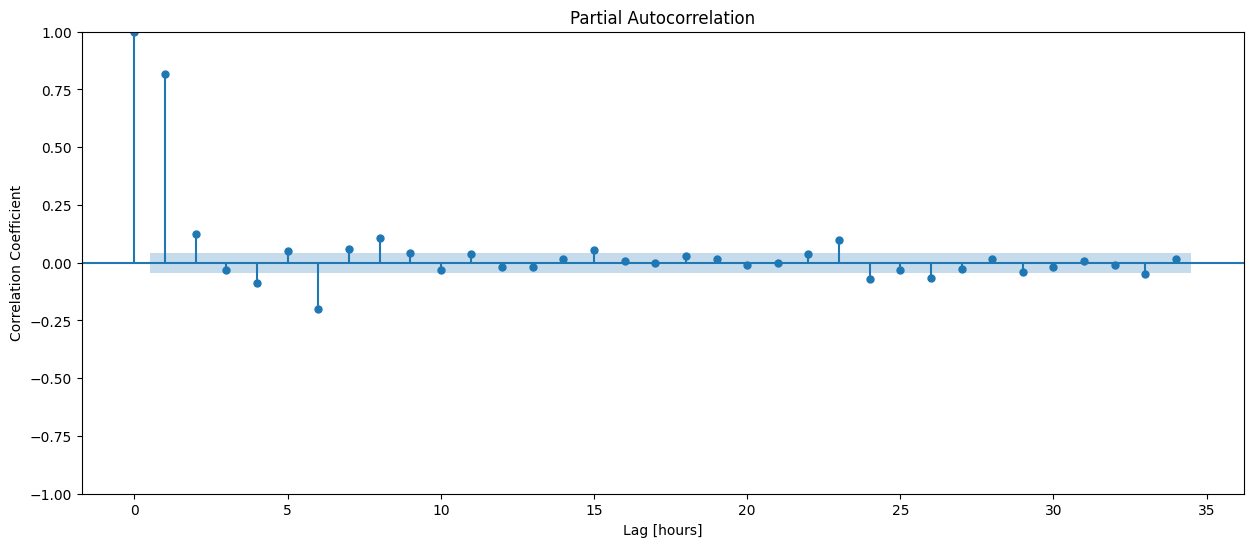

In [7]:
# Creating an PACF plot to display autocorrelation coefficients
fig, ax = plt.subplots(figsize = (15,6))
plot_pacf(df_dar, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

The ACF and PACF plots are valuable tools for determining optimal values for P and Q in our model. It seems that P could be around 8, as indicated by the PACF plot, while Q might be around 2, based on where autocorrelation values drop off in the ACF plot.




In [8]:
# Split into training and test sets
y = df_dar
y_train = y.loc["2019-04-01 00:00:00+03:0" : "2019-04-30 23:00:00+03:0"]
y_test = y.loc["2019-05-01 00:00:00+03:0" : "2019-05-01 23:00:00+03:0"]

In [9]:
# Calculating the baseline mean absolute error
y_pred_baseline = len(y_train) * [y_train.mean()]
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 10.44
Baseline MAE: 6.71


#### **Hyperparameter Tuning**

In [10]:
#Create ranges for possible 𝑝 and 𝑞 values. With p ranging between 0 and 25, by steps of 8 and q ranging between 0 and 3 by steps of 1.
p_params = range(0, 25, 8)
q_params = range(0, 3, 1)

In [11]:
# Creating dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterating through possible values for `p`
for p in p_params:
    # Creating key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = []
    # Inner loop: Iterating through possible values for `q`
    for q in q_params:
        #Set the HP for the model
        order = (p, 0, q)
        #To calculate how long the process takes for each model fit
        start_time = time.time()

        #Training model
        model = ARIMA(y_train, order = order).fit()
        elapsed_time = round(time.time() - start_time, 2)

        print(f"Trained ARIMA model {order} in {elapsed_time} seconds.")

        #Generating in-sample predictions
        y_pred = model.predict()

        #Calculating training MAE
        mae = mean_absolute_error(y_train, y_pred)

        # Appending MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA model (0, 0, 0) in 0.31 seconds.
Trained ARIMA model (0, 0, 1) in 0.27 seconds.
Trained ARIMA model (0, 0, 2) in 0.62 seconds.
Trained ARIMA model (8, 0, 0) in 3.12 seconds.
Trained ARIMA model (8, 0, 1) in 3.41 seconds.
Trained ARIMA model (8, 0, 2) in 6.23 seconds.
Trained ARIMA model (16, 0, 0) in 5.46 seconds.
Trained ARIMA model (16, 0, 1) in 5.05 seconds.
Trained ARIMA model (16, 0, 2) in 22.05 seconds.
Trained ARIMA model (24, 0, 0) in 12.36 seconds.
Trained ARIMA model (24, 0, 1) in 9.99 seconds.
Trained ARIMA model (24, 0, 2) in 16.27 seconds.

{0: [6.711560142075985, 5.379017592233921, 5.037732163240906], 8: [4.50961167188067, 4.536120052335671, 4.617890283004287], 16: [4.699317132254199, 4.700234374130003, 4.729807236510245], 24: [4.753292807439779, 4.75641329813349, 4.756847780287644]}


In [12]:
# Organizing all the MAE's from above in a DataFrame
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,6.7116,4.5096,4.6993,4.7533
1,5.3790,4.5361,4.7002,4.7564
2,5.0377,4.6179,4.7298,4.7568


Based on the MAE values above and considering the trade-off with computational time, (8, 0, 0) appears to be a favorable set of hyperparameters.

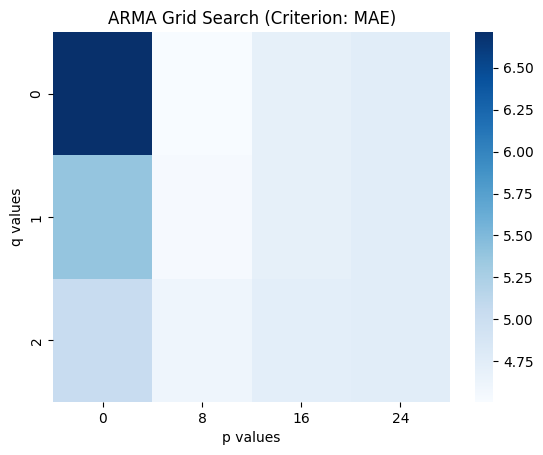

In [13]:
# Creating a heatmap of the values in mae_grid
sns.heatmap(mae_df, cmap = "Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (Criterion: MAE)");

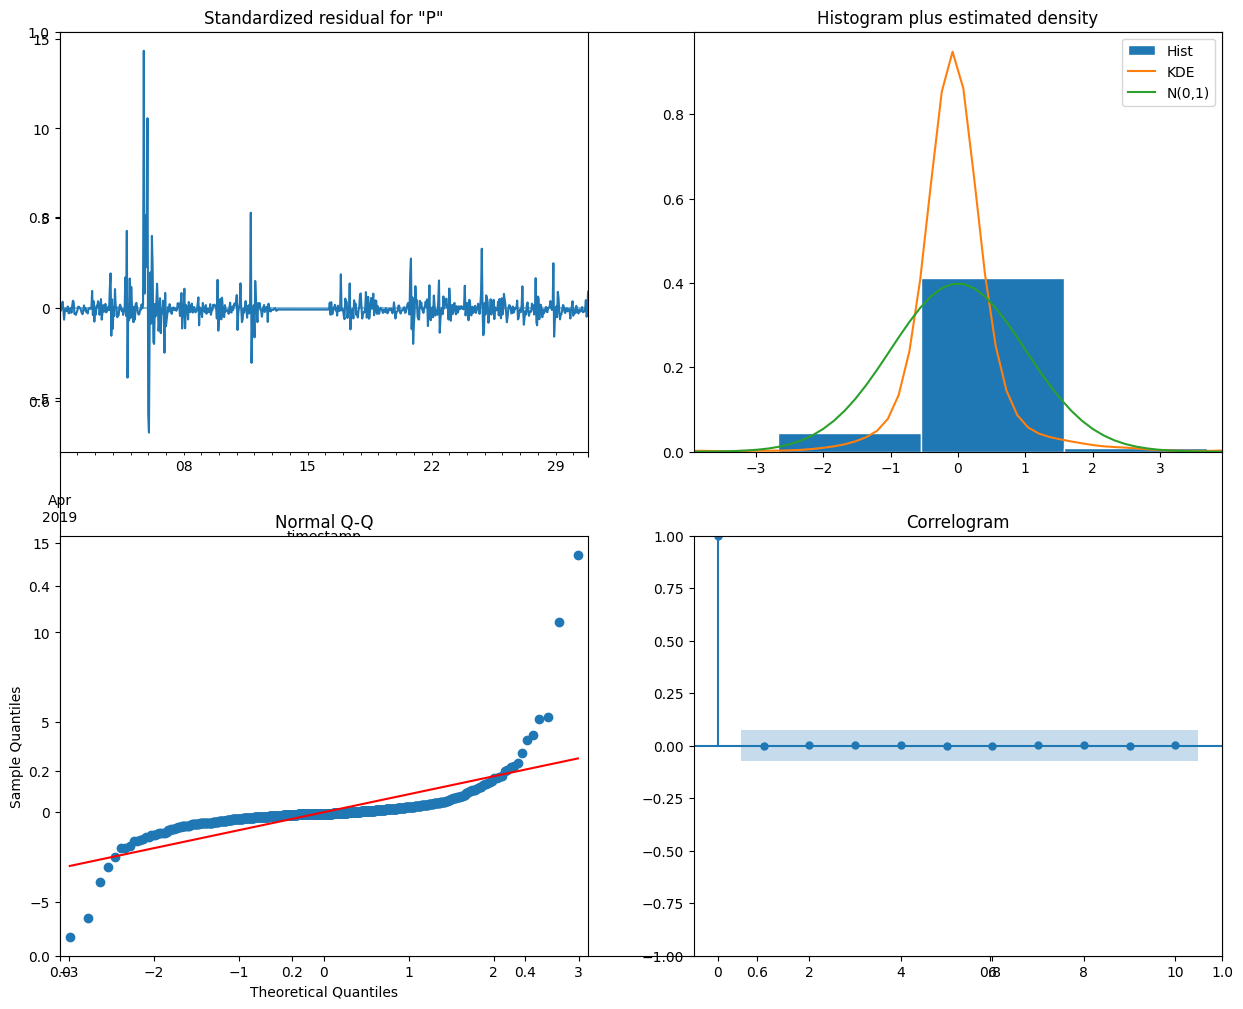

In [14]:
# Using the plot_diagnostics method to check the residuals for the model
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

From the above, it can be seen that the histogram could better align with the green distribution plot and has room for improvement. On the other hand, the correlogram appears satisfactory.

#### **Model's result**

In [15]:
# Performing walk-forward validation for the model for the entire test set.
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(8, 0, 0)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

Storing the model's predictions in the Series y_pred_wfv to choose the values for 𝑝 and 𝑞 that best balance model performance and computation time.

In [16]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 2.27


Test MAE is pretty good and better than our Baseline MAE (6.71)

In [17]:
# Generating predictions to test model's performance
df_predictions = pd.DataFrame(
    {
        "y_test" : y_test,
        "y_pred_wfv" : y_pred_wfv
    }

)
fig = px.line(df_predictions, labels = {"value" : "PM2.5"})
fig.show()

The predicted values align with the overall trend, but enhancing the model could be achieved with additional resources for hyperparameter tuning.